# Dimensionless SE
We work in units

$$ x=r_0 \hat{r}; \quad t = 2mr_0^2 \hat{t}; \quad \psi = \psi_0 \hat{\psi}$$
such that the nonlinear Schrodinger Equation takes the form:
$$ i \hat{\psi}' = -\hat{\nabla}^2 \hat{\psi} + \epsilon |\hat{\psi}|^2\hat{\psi}$$
where $(...)'$ denotes dimensionless time derivative and
$$\epsilon = g m r_0^2\psi_0^2$$. We will take $r_0$ to be some input de Broglie wavelength, and $\psi_0 = \sqrt{\rho_{0}/m}$.

## Weakly nonlinear regime
Let us work in the kinetic regime where gravity is negligable.
<!-- We have turned off gravity. This is reasonable if ...

Further conditions:

Try to impose that the simulation time $T$ satisfies:

$$T \ll t_{\text{cross}}$$
where $t_{\text{cross}}$ is the crossing time for the fast mode $k_{max}$:
$$
t_{\text{cross}} = \frac{mL}{k_{max}}.
$$
This means most modes will not cross the boundary. -->

From testing, it seems that there is a quick 'relaxation' period where $\delta_{rms}$ drops off. I think this corresponds to the Nyquist time:
$$
t_{Nyq} = \frac{2\pi}{\omega_{Nyq}} = \frac{4 \pi m}{k_{max}^2}.
$$

We ideally want to run it for multiple de Broglie oscillations:
$$
t_{dB} = \frac{m}{k_0^2}
$$



# Loop over couplings

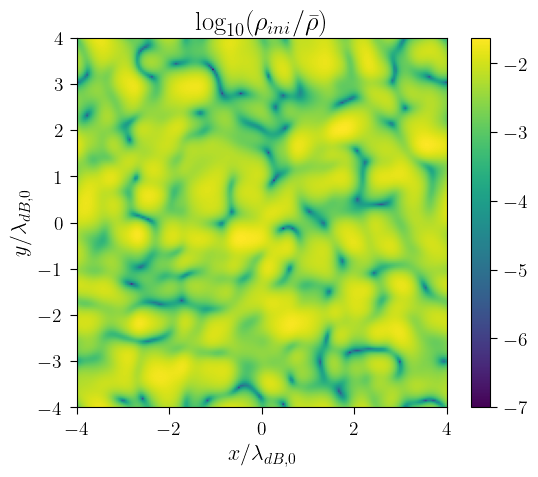

number steps:7972


In [1]:
from RandomPhaseGenerator import RandomPhase2d
from PowerSpectrum import PowerSpectrum2d
from SchroPoissonSolver import fdmSimulation2d
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import rc, rcParams
# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to ‘Computer Modern’
rc('font',**{'size':16, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=5)
rc('xtick', labelsize=14)
rc('ytick.major', size=5, pad=5)
rc('ytick', labelsize=14)

"""
#The "pipeline" function accepts 2d initial density field and simulates Schrodinger evolution
over input range of dimensionless couplings.

#In this notebook we use random phase initial conditions, generated by call to "RandomPhase2d."

#Simulation calls the function "fdmSimulation2d," which uses symplectic kick-drift-kick (leapfrog) integration.
"""

def pipeline(rho_init, length, resolution, pow_dt, t_end, avg_density, couplings):
    norm = avg_density # dimensionless
    N = resolution
    N_half = int(N/2)
    N_g = couplings.size

    t_cross = L/k_max/2 #dimensionless crossing time of box
    dt = (1/N)**pow_dt #temporal resolution
    N_steps = int(t_end/dt)

    print("number steps:"+str(N_steps)) # how many time steps

    Nt_saved = int(N_steps/2)
    
    # initialize arrays 
    PS_array = np.zeros((N_g, N_half))
    deltas_array = []#np.zeros((N_g, Nt_saved))
    psis_array = np.zeros((N_g, Nt_saved, N, N), dtype=complex)
    
    # loop over couplings
    i = 0
    for g in couplings:
        deltas, psis, t_vals = fdmSimulation2d(rho_init, norm, length, 0, g, t_end, dt, Nt_saved)

        # time average power spectrum
        spectra = []

        for j in range(Nt_saved):
            k_modes, PS = PowerSpectrum2d(np.abs(psis[j,:,:])**2, length)
            spectra.append(PS)
            
        PSavg = np.average(spectra, axis=0)  
        PS_array[i,:] = PSavg
        deltas_array.append(deltas)
        psis_array[i,:,:,:] = psis

        i += 1
    return t_vals, np.asarray(deltas_array), k_modes, PS_array, psis_array



dB = 1 # inital wavelength of random phase density field
L = 8*dB # box size in de Broglie lengths
N = 25*L #s patial res. along single axis

k_dB = 2*np.pi / dB # de Broglie wave number
k_min = 2*np.pi/L
k_max = 2*np.pi*N/L

t_dB = np.pi/k_dB**2 # de Broglie osc. time
t_cross = L/k_max/2


# generate initial conditions and compute power spectrum
psi0, rho0 = RandomPhase2d(N, dB, L)
k_modes, PS0 = PowerSpectrum2d(rho0, L)

# plot initial condition
plt.figure()
plt.title(r"$\log_{10}(\rho_{ini} / \bar{\rho})$")
plt.imshow((np.log10(rho0)), extent
           =[-L/dB/2, L/dB/2,
             -L/dB/2, L/dB/2])
plt.colorbar()
plt.xscale("linear")
plt.yscale("linear")
plt.xlabel(r"$x/\lambda_{dB,0}$")
plt.ylabel(r"$y/\lambda_{dB,0}$")
plt.savefig("random-phase-IC.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

norm = 1e0
power = 1.65 # dt = dx**power, ideally power = 2 (slow!)

rho0 *= N*norm # match normalization of simulation

epsilons = np.array([0, -0.1, -0.05, 0.05, 0.1]) #put e=0 first
# epsilons = np.array([0,-5e-2,5e-2])

tf = 50*t_cross # total time in units of crossing time

t_vals, deltas, k_modes, spectra, psis = pipeline(rho0, L/dB, N, power, tf, norm, epsilons)

In [2]:
# Check conservation of total mass

Si = np.sum(np.abs(psis[-1,0,:,:])**2)
Sf = np.sum(np.abs(psis[-1,-1,:,:])**2)

print(np.sum(rho0))
print(Sf)

40000.0
40000.000000021304


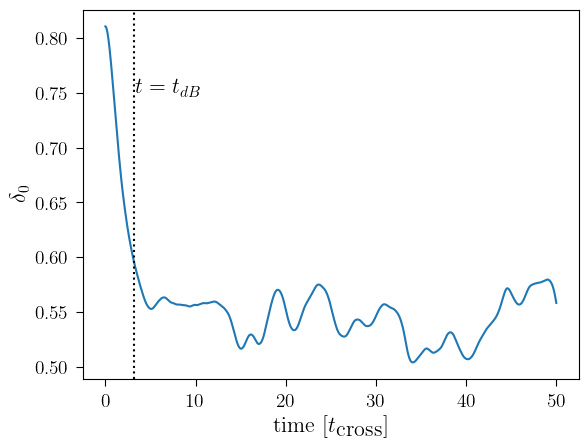

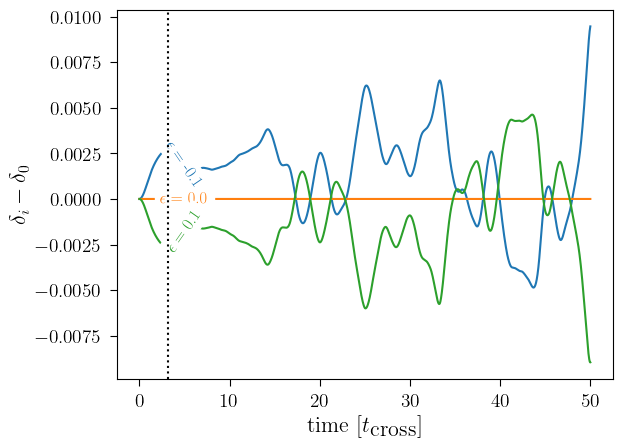

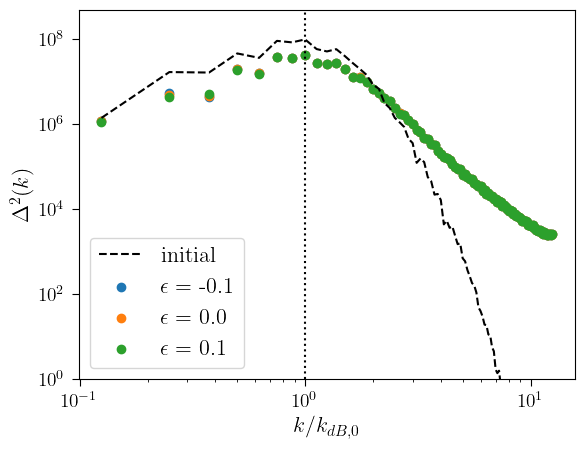

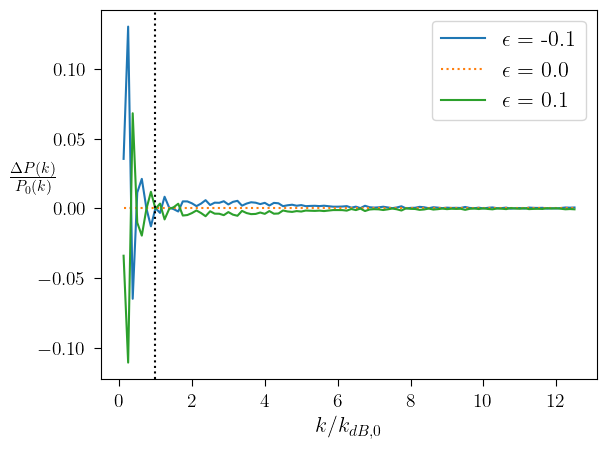

In [3]:
# !pip install matplotlib-label-lines
from labellines import labelLines

## Plot rms delta over time

plt.figure()
plt.plot(np.asarray(t_vals)/t_cross,  deltas[0,:])
plt.axvline(x=t_dB/t_cross, color="k", linestyle=":")
plt.text(t_dB/t_cross+.2, .75, r"$t=t_{dB}$")
# plt.legend()
plt.ylabel(r"$\delta_{0}$")
plt.xlabel(r"time [$t_{\textrm{cross}}$]")
plt.savefig("contrast.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()
##

## Plot relative delta at different couplings

plt.figure()
i=0
# for g in epsilons:
#     plt.plot(np.asarray(t_vals)/t_cross,  deltas[i,:]- deltas[0,:], label = r"$\epsilon=$ "+str(g))
#     i+= 1
plt.plot(np.asarray(t_vals)/t_cross,  deltas[1,:]- deltas[0,:], label = r"$\epsilon=$ "+str(epsilons[1]))
plt.plot(np.asarray(t_vals)/t_cross,  deltas[0,:]- deltas[0,:], label = r"$\epsilon=$ "+str(epsilons[0]))
plt.plot(np.asarray(t_vals)/t_cross,  deltas[-1,:]- deltas[0,:], label = r"$\epsilon=$ "+str(epsilons[-1]))
labelLines(plt.gca().get_lines(), xvals = [5]*len(epsilons) ,zorder=2., backgroundcolor="white", fontsize=12)
plt.axvline(x=t_dB/t_cross, color="k", linestyle=":")
plt.ylabel(r"$\delta_i-\delta_{0}$")
plt.xlabel(r"time [$t_{\textrm{cross}}$]")
plt.savefig("contrast-comparison.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()
##

## Plot time-averaged dimensionless power spectra

plt.figure()
i=0
plt.plot(k_modes/k_dB, k_modes**2*PS0, linestyle="--", color="k", label="initial")
# for g in epsilons:
#     plt.scatter(k_modes/k_dB, k_modes**2*(spectra[i,:]), label = r"$\epsilon=$ "+str(g))
#     i+= 1
# plt.axvline(x=t_dB/t_vals[-1])
plt.scatter(k_modes/k_dB, k_modes**2*spectra[1,:], label = r"$\epsilon=$ "+str(epsilons[1]))
plt.scatter(k_modes/k_dB, k_modes**2*spectra[0,:], label = r"$\epsilon=$ "+str(epsilons[0]))
plt.scatter(k_modes/k_dB, k_modes**2*spectra[-1,:], label = r"$\epsilon=$ "+str(epsilons[-1]))
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$k /k_{dB,0}$")
plt.ylabel(r"$\Delta^2(k)$")
plt.axvline(x=1, color="k", linestyle=":")
plt.ylim(1, 5e8)
plt.savefig("power-spectrum.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()
##

## Plot fractional diff. of spectra
plt.figure()
# i=0
# for g in epsilons:
#     plt.plot(k_modes/k_dB,(spectra[i,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(g))
#     i+= 1
# plt.axvline(x=t_dB/t_vals[-1])
# plt.legend()
plt.plot(k_modes/k_dB,(spectra[1,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(epsilons[1]))
plt.plot(k_modes/k_dB,(spectra[0,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(epsilons[0]), linestyle=":")
plt.plot(k_modes/k_dB,(spectra[-1,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(epsilons[-1]))
plt.yscale("linear")
# plt.xscale("log")
plt.xlabel(r"$k /k_{dB,0}$")
plt.ylabel(r"$\frac{\Delta P(k)}{P_0(k)}$", rotation=0)
# labelLines(plt.gca().get_lines(), xvals = [.075]*len(epsilons) ,zorder=2., backgroundcolor="white", fontsize=10)
plt.axvline(x=1, color="k", linestyle=":")
# plt.xlim(.95,1.05)
plt.legend()
plt.savefig("fractional-power-spectrum.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

In [4]:
from scipy.optimize import curve_fit


Nt =[i for i in range(len(t_vals)) if t_vals[i] < t_dB][-1] # index of t_dB


corrections = np.average(deltas[:, Nt:], axis=1) #average over t>t_dB
corrections -= corrections[0] # Delta of delta 

# fit function
def fit(eps, a):
    return  1 - a*norm*eps*t_dB

popt, pcov = curve_fit(fit,  epsilons, corrections)

slope = popt[0]

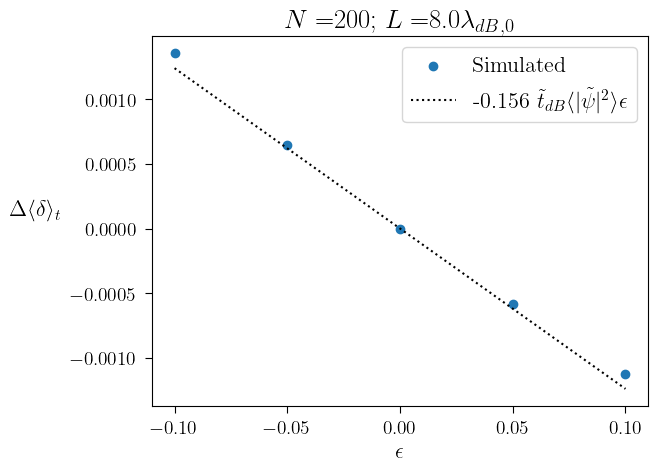

In [5]:
plt.figure()
plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
plt.scatter(epsilons, corrections, label="Simulated")
plt.plot(epsilons[1:], corrections[0]-slope*norm*t_dB*epsilons[1:], label=str(round(-slope,3))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$",linestyle=":",color="k")
# plt.ylabel(r"$\frac{\Delta\langle \delta\rangle_t}{\langle \delta_0\rangle_{t}}$",rotation=0, labelpad=20)
plt.ylabel(r"$\Delta\langle \delta\rangle_t$",rotation=0, labelpad=25)
plt.xlabel(r"$\epsilon$")
plt.legend()
plt.savefig("density-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

Notice that the slope is:
$$ \sim \tilde{t}_{dB}\langle |\tilde{\psi}|^2 \rangle \epsilon = \tilde{t}_{dB}\langle |\tilde{\psi}|^2 \rangle g \rho_0 r_0^2  = \tilde{t}_{dB}\langle |\tilde{\psi}|^2 \rangle g \rho_0 \frac{t_0}{2m} =  g \frac{t_{dB}\langle |\psi|^2 \rangle}{2} = g\frac{\lambda_{dB}^2 \bar{\rho}}{2}$$

### Expectation value of $k$:

$P(k)$ has the right dimensions to be a probability density function over $k$-space. Let's take that literally for a moment and compute the expected value of $k$:

$$E[k] = \int d^dk P(k) k.$$

We can try using this $k$ to compute corrections at different couplings:

$$ \frac{\delta k}{k_0} \equiv \frac{\int d^dk \langle P(k, \epsilon \neq 0)\rangle_t k }{\int d^dk \langle P(k, \epsilon = 0)\rangle _t}  - 1$$

In [6]:
kexp = np.zeros((epsilons.size))

n = 0
for e in epsilons:
#     kexp[n] = np.sqrt(np.sum(k_modes**2*spectra[n,:])) #RMS value
    kexp[n] = (np.sum(k_modes*(spectra[n,:])))
    n += 1

dk = kexp/kexp[0] - 1

def fitk(eps, b):
    return  - b*norm*eps*t_dB


poptk, pcovk = curve_fit(fitk,  epsilons, dk)

slopek = poptk[0]

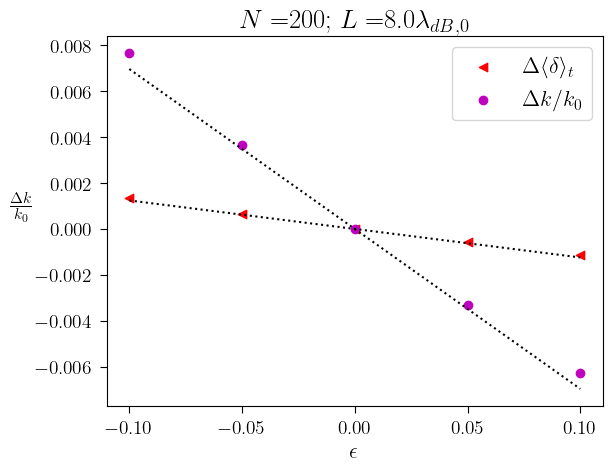

In [7]:
plt.figure()
plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
plt.scatter(epsilons, corrections, marker="<", color="r", label=r"$\Delta\langle \delta\rangle_t$")
plt.plot(epsilons[1:], corrections[0]-slope*norm*t_dB*epsilons[1:],linestyle=":",color="k")#, label=str(round(-slope,3))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$",linestyle=":",color="k")
plt.scatter(epsilons, dk, label=r"$\Delta k/k_{0}$", color="m")
plt.plot(epsilons[1:], -slopek*norm*t_dB*epsilons[1:],linestyle=":",color="k")#, label=str(-round(slopek,3))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$",linestyle=":",color="k")
plt.ylabel(r"$\frac{\Delta k}{k_{0}}$",rotation=0, labelpad=10)
plt.xlabel(r"$\epsilon$")
plt.legend()
plt.savefig("k-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

In [8]:
slope/slopek # compare delta scaling with k scaling

0.1782304202838812

<!-- so evidently 
$$\boxed{ \delta = 1 + \frac{1}{d}\frac{\delta k}{k_0}}$$
whereas I would have predicted 
$$\delta = 1 + d\frac{\delta k}{k_0} $$
in $d$ spatial dimensions. -->

### Speed distribution

Let's try looking at the phase of the wavefunction. In the fluid description,
$$\mathbf{v} = -\frac{1}{m}\nabla \arg \psi$$

In [9]:
thetas = np.angle( psis[:,-1,:,:]) # final time snapshot

velocities = np.gradient(-thetas,  L/N, axis=(1,2)) # dx = L/N, axis (2,3) are spatial parts of array

In [10]:
speeds = np.linalg.norm(velocities, ord=1, axis = 0) # gradient introduces new axis 0 with length 2
speeds = speeds.reshape((epsilons.shape[0], N*N))
np.shape(speeds)

(5, 40000)

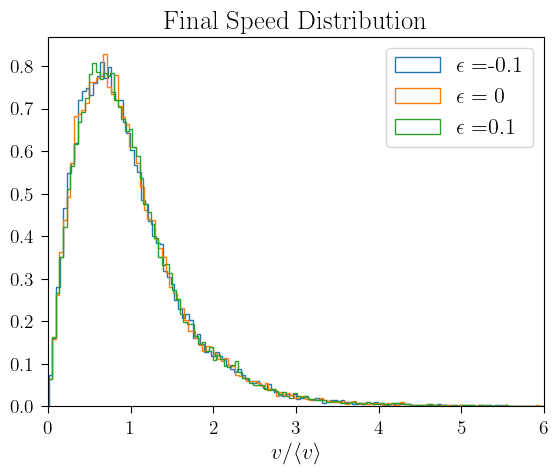

In [11]:
plt.figure()
plt.title("Final Speed Distribution")
plt.hist(speeds[1,:]/np.average(speeds[1,:]), bins="auto", label=r"$\epsilon=$"+str(epsilons[1]), density=True, histtype="step")
plt.hist(speeds[0,:]/np.average(speeds[0,:]), bins="auto", label=r"$\epsilon=0$", density=True, histtype="step")
plt.hist(speeds[-1,:]/np.average(speeds[-1,:]), bins="auto", label=r"$\epsilon=$"+str(epsilons[-1]), density=True, histtype="step")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$v/\langle v \rangle$")
plt.xlim(0,6)
plt.legend()
plt.savefig("speed-dist.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

In [12]:
mean_speeds = np.average(speeds, axis=1)
stds = np.std(speeds, axis = 1)

dv = mean_speeds/mean_speeds[0]-1
dsigma = stds/stds[0]-1

def func(eps, a):
    return a*t_dB*norm*eps

popt1, pcov1 = curve_fit(func,  epsilons, dv)
popt2, pcov2 = curve_fit(func,  epsilons, dsigma)

slope_v = popt1[0]
slope_sigma = popt2[0]

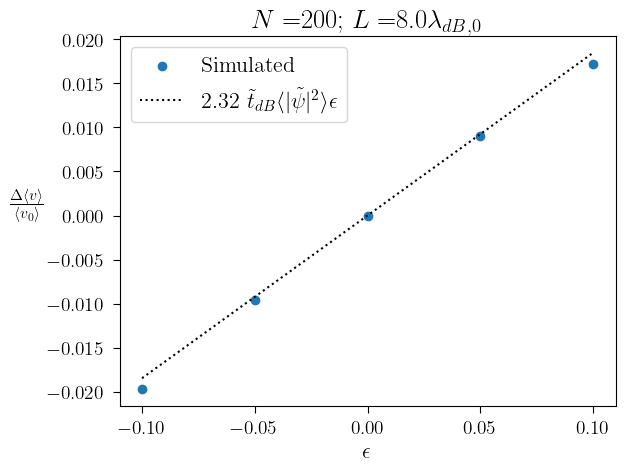

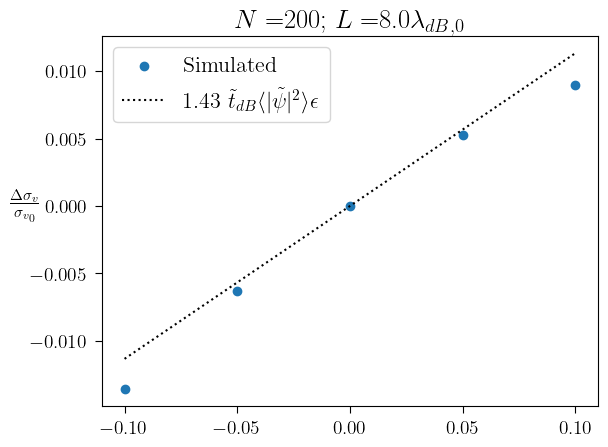

In [13]:
## Plot Dv / v
plt.figure()
plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
plt.scatter(epsilons, dv, label="Simulated")
plt.plot(epsilons[1:], slope_v*t_dB*norm*epsilons[1:], linestyle=":", color="k", label=str(round(slope_v,2))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$")
plt.ylabel(r"$\frac{\Delta \langle v\rangle }{\langle v_{0} \rangle}$", rotation=0, labelpad=15)
plt.xlabel(r"$\epsilon$")
plt.legend()
plt.savefig("velocity-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()
##

## Plot Dsigma / sigma
plt.figure()
plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
plt.scatter(epsilons, dsigma, label="Simulated")
plt.plot(epsilons[1:], slope_sigma*t_dB*norm*epsilons[1:], linestyle=":", color="k", label=str(round(slope_sigma,2))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$")
plt.ylabel(r"$\frac{\Delta \sigma_v}{\sigma_{v_0}}$", rotation=0)
# plt.xlabel(r"$\epsilon$")
plt.legend()
plt.savefig("sigma-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()
##

## Calculate $\xi_2(r)$ (untested)

$$ \xi_2(\mathbf{r}) = \frac{1}{V}\int d^3x \delta(\mathbf{x})\delta(\mathbf{x-r})=(\delta*\delta)$$

In [14]:
from scipy.signal import correlate2d, fftconvolve

def compute_2point_correlation(delta):
    # Compute the autocorrelation function using the FFT method
    autocorrelation = correlate2d(delta, delta)

    # Compute the 2-point correlation function
    correlation_function = autocorrelation[int(autocorrelation.shape[0]/2), int(autocorrelation.shape[1]/2):]

    return correlation_function / correlation_function[0]


In [15]:
lvals = np.linspace(0, L, N) # radial values

# initialize
correlation_functions = np.zeros((epsilons.shape[0] , N))
correlation0 = compute_2point_correlation(rho0)
lengths = []

#compute xi over range of couplings
for i in range(epsilons.shape[0]):
    cf = compute_2point_correlation(np.abs(psis[i,-1,:,:])**2)
    correlation_functions[i,:] = cf
    lengths.append( lvals[ np.argwhere(cf < cf[0]/np.exp(2))[0]] )


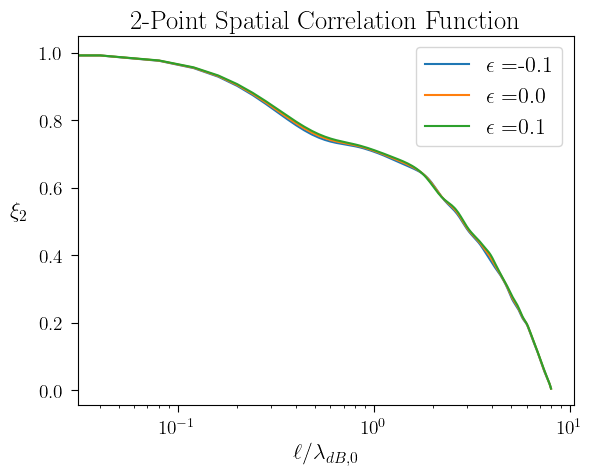

In [16]:
plt.figure()
# plt.plot(xvals/dB, correlation0)
# for i in range(epsilons.shape[0]):
#     plt.plot(xvals/dB, correlation_functions[i,:], label=r"$\epsilon=$"+str(epsilons[i]))
plt.plot(lvals/dB, correlation_functions[1,:], label=r"$\epsilon=$"+str(epsilons[1]))
plt.plot(lvals/dB, correlation_functions[0,:], label=r"$\epsilon=$"+str(epsilons[0]))
plt.plot(lvals/dB, correlation_functions[-1,:], label=r"$\epsilon=$"+str(epsilons[-1]))
# plt.axvline(x=1, linestyle=":", color="k")
plt.title("2-Point Spatial Correlation Function")
plt.xlabel(r"$\ell/\lambda_{dB,0}$")
plt.ylabel(r"$\xi_2$", rotation=0, labelpad=15)
plt.xscale("log")
# plt.yscale("log")
# plt.xlim(0.05,2)
# plt.xlim(.1,1)
plt.legend()
plt.savefig("2pt-function.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

# Expectation value of $k$

Instead of using ad hoc method, use $$ \langle k \rangle \sim \mathcal{V} \sum_x \psi(x) \nabla \psi^*(x) $$

In [17]:
grad = np.asarray(np.gradient(psis[:,-1,:,:],  L/N, axis=(1,2))) # dx = L/N, axis (1,2) are spatial parts of array

In [18]:
k_x, k_y = psis[:,-1,:,:]*grad[0,:,:,:], psis[:,-1,:,:]*grad[1,:,:,:]

In [19]:
kexp_x, kexp_y = np.sum(k_x, axis=(1,2)), np.sum(k_y, axis=(1,2)) # sum over box
kexp_vec = np.array([kexp_x,kexp_y])

In [20]:
kexp = np.linalg.norm(kexp_vec, axis = (0))

In [21]:
dkexp = kexp/kexp[0]-1
dkexp

array([ 0.        ,  0.02241397,  0.0114273 , -0.01184085, -0.02405467])

## Imaginary expectation values???

# Probability current
Try instead
$$ \mathbf{j}=\rho\mathbf{v} = -\frac{i}{2}\left(\psi^* \nabla \psi - c.c. \right)$$

In [22]:
current = -1j*(np.conj(psis[:,-1,:,:])*grad - psis[:,-1,:,:]*np.conj(grad))/2
np.shape(current)

(2, 5, 200, 200)

In [23]:
current_norm = np.linalg.norm(current, axis=(0))#/ np.linalg.norm(psis[:,-1,:,:], ord = 2, axis=0)
current_norm = np.reshape(current_norm,(epsilons.size, N*N))
np.shape(np.linalg.norm(psis[:,-1,:,:], ord = 2, axis=0))

(200, 200)

In [24]:
jvals = np.average(current_norm, axis = 1)
dj = jvals/jvals[0]-1
dj

array([ 0.        , -0.0265536 , -0.01314569,  0.01275644,  0.02499179])

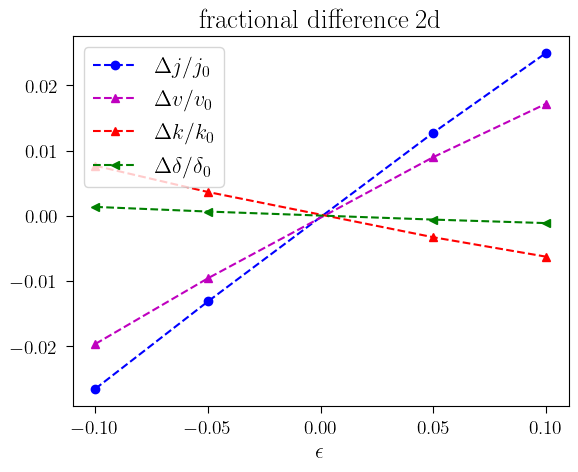

In [25]:
## compute change in total mass

dM = []
for i in range(epsilons.shape[0]):
    dM.append( np.sum(np.abs(psis[i,-1])**2)/np.sum(rho0) - 1 )
dM = np.asarray(dM)


popt2, pcov2 = curve_fit(func,  epsilons, dM)
##
#
## Plot everything at once

plt.figure()
# for i in range(epsilons.shape[0]):
#     dM = np.sum(np.abs(psis[i,-1])**2)/np.sum(rho0) - 1
#     plt.scatter(epsilons[i], dM)
# plt.plot(epsilons[1:], dM[1:], label= r"$\Delta M/M_0$", color="k")
plt.plot(epsilons[1:], dj[1:],"--bo", label = r"$\Delta j /j_0$" )
plt.plot(epsilons[1:], dv[1:],"--m^" ,label = r"$\Delta v /v_0$")
plt.plot(epsilons[1:], dk[1:], "--r^" ,label = r"$\Delta k /k_0$")
plt.plot(epsilons[1:], corrections[1:], "--g<" ,label = r"$\Delta \delta /\delta_0$")
# plt.plot(epsilons[1:], dsigma[1:],  label= r"$\Delta \sigma/\sigma_0$")
plt.legend()
# plt.yscale("symlog")
# plt.xscale("symlog")
plt.title("fractional difference 2d")
plt.xlabel(r"$\epsilon$")
plt.savefig("frac-diff-2d.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

# A qualitative zoom-in
Look at a 1d sub-region

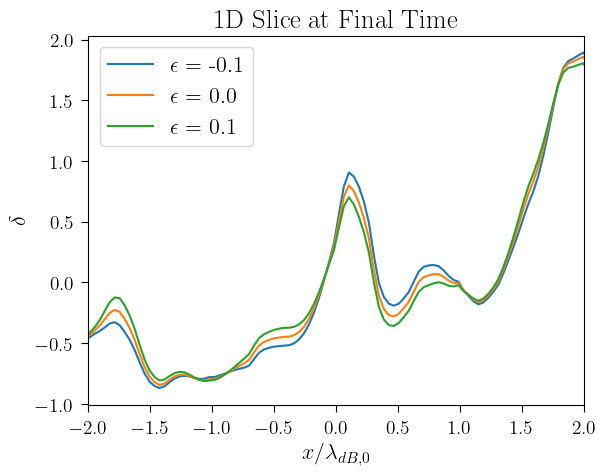

In [26]:
xvals = np.linspace(-L/2, L/2, N)

psis_slice = psis[:,-1,int(N/2),:]
rhos_slice = np.abs(psis_slice)**2

deltas_slice = rhos_slice 
for i in range(epsilons.shape[0]):
    deltas_slice[i,:] = deltas_slice[i,:]/np.average(rhos_slice[i,:])-1
    
plt.figure()
plt.title("1D Slice at Final Time")
plt.ylabel(r"$\delta$")
plt.xlabel(r"$x/\lambda_{dB,0}$")
plt.plot(xvals/dB,deltas_slice[1,:], label =r"$\epsilon=$ "+str(epsilons[1]))
plt.plot(xvals/dB, deltas_slice[0,:], label =r"$\epsilon=$ "+str(epsilons[0]) )
plt.plot(xvals/dB,deltas_slice[-1,:], label =r"$\epsilon=$ "+str(epsilons[-1]))#, linestyle=":")
plt.legend()
plt.xlim(-2,2)
# plt.ylim(-.15,1.15)
plt.savefig("test-granule.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()